In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from skmisc.loess import loess

In [3]:

# Load the data from the provided CSV file
data_url = "https://liangfgithub.github.io/Data/Coding3_Data.csv"
data = pd.read_csv(data_url)
x = data['x'].values
y = data['y'].values



In [4]:

# Define the true curve function
def true_curve(x):
    return np.sin(12 * (x + 0.2)) * (x + 0.2)

In [5]:
def smooth(x, span):
    x_sort = np.sort(x, axis=0)
    y = true_curve(x)
    #print(y)
    loess_model = loess(x, y,span=span)
    #print("predicted ")
    return loess_model.predict(x_sort).values
    

In [6]:
def compute_diagonal(x, span):
    #print(len(x))
    smoothed_matrix = smooth(x, span)
    diagonal = np.diag(smoothed_matrix).reshape(-1,1)
    #print(f"diagonal_matrix_shape: {diagonal.shape}")
    return diagonal

In [7]:
diag = compute_diagonal(x,0.20)

In [8]:
# Function to perform LOO-CV for a given span
def loo_cv(x, y, span):
    diag = compute_diagonal(x, span)
    residuals = diag - y
    mse = np.mean(residuals ** 2)
    return mse

# Function to perform GCV for a given span
def gcv(x, y, span):
    diag = compute_diagonal(x, span)
    residuals = diag - y
    mse = np.mean(residuals ** 2)
    gcv_value = mse / ((1 - span) ** 2)
    return gcv_value


In [9]:
cv_values = []
gcv_values = []
span_values = np.arange(0.20, 0.95, 0.05)
for span in span_values:
    cv = loo_cv(x, y, span)
    gcv_val = gcv(x, y, span)
    cv_values.append(cv)
    gcv_values.append(gcv_val)

# Find the optimal span based on CV and GCV
optimal_span_cv = span_values[np.argmin(cv_values)]
optimal_span_gcv = span_values[np.argmin(gcv_values)]

print("Optimal Span (CV):", optimal_span_cv)
print("Optimal Span (GCV):", optimal_span_gcv)


Optimal Span (CV): 0.7499999999999998
Optimal Span (GCV): 0.2


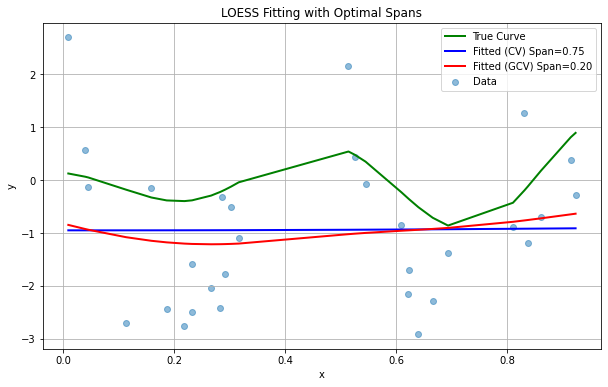

In [10]:
# Plot the original data, true curve, and fitted curve using optimal spans
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="Data", alpha=0.5)
plt.plot(x, true_curve(x), label="True Curve", color='green', linewidth=2)

# Plot the fitted curve using the optimal span for CV
fitted_curve_cv = np.array([np.nan] * len(x))
for i in range(len(x)):
    weights = np.exp(-0.5 * ((x - x[i]) / optimal_span_cv) ** 2)
    fitted_curve_cv[i] = np.sum(weights * y) / np.sum(weights)
plt.plot(x, fitted_curve_cv, label=f"Fitted (CV) Span={optimal_span_cv:.2f}", color='blue', linewidth=2)

# Plot the fitted curve using the optimal span for GCV
fitted_curve_gcv = np.array([np.nan] * len(x))
for i in range(len(x)):
    weights = np.exp(-0.5 * ((x - x[i]) / optimal_span_gcv) ** 2)
    fitted_curve_gcv[i] = np.sum(weights * y) / np.sum(weights)
plt.plot(x, fitted_curve_gcv, label=f"Fitted (GCV) Span={optimal_span_gcv:.2f}", color='red', linewidth=2)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("LOESS Fitting with Optimal Spans")
plt.grid(True)
plt.show()

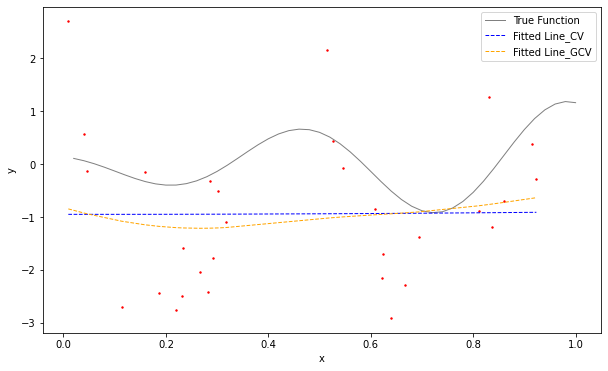

In [11]:
plt.figure(figsize=(10, 6))
fx = np.arange(1, 51, 1)/50
fy = true_curve(fx)
plt.scatter(x, y, color="red", s=2)
plt.plot(fx, fy, color="gray", linewidth=1, label="True Function")
plt.plot(x,fitted_curve_cv, color="blue",
         linestyle="dashed", linewidth=1, label="Fitted Line_CV")
plt.plot(x,fitted_curve_gcv, color="orange",
         linestyle="dashed", linewidth=1, label="Fitted Line_GCV")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()